# Implementación del Problema de Optimización de Carteras con Computador Cuántico Adiabático

Este cuaderno describe la implementación de un problema de optimización de carteras de inversiones utilizando un computador cuántico adiabático. El enfoque adoptado es el del "Minimum Volatility Portfolio", utilizando variables binarias para la selección de activos. El objetivo principal es minimizar el riesgo total de la cartera, modelado por la fórmula:

$$\min \sum_{i,j} x_i \cdot w_{ij} \cdot x_j$$

donde $x_i$ representa la inclusión (1) o no (0) del activo $i$ en la cartera, y $w_{ij}$ es el término de covarianza entre los activos $i$ y $j$.

Además, se establece una restricción sobre el retorno esperado de la cartera, asegurando que sea al menos igual a un umbral predefinido. Esto se modela con una variable slack y se expresa como:

$$R \leq \sum_{i} x_i \cdot r_i$$

donde $r_i$ es el retorno esperado del activo $i$.

Finalmente, como condición adicional, se determina que solo se quiere invertir en la mitad de las empresas disponibles. Esto se traduce en la restricción:

$$\sum_{i} x_i = \frac{N}{2}$$

donde $N$ es el número total de activos disponibles.



In [ ]:
!pip install -r "requirements_unix.txt"

Processing ./dadk_light_3.10.tar.bz2
  Preparing metadata (setup.py) ... done
  Created wheel for dadk: filename=dadk-2023.12.10-py3-none-any.whl size=4995459 sha256=dc8badfc9945dbac0a0e7af027bd5d810447b14f2ad934056401f34e3786f982
  Stored in directory: /tmp/pip-ephem-wheel-cache-vi9k4bvy/wheels/78/36/68/08dcbec0b48f137a33fc3ac474d3838f74984d2dda7e3178dd
Successfully built dadk
  Attempting uninstall: dadk
    Found existing installation: dadk 2023.12.10
    Uninstalling dadk-2023.12.10:
      Successfully uninstalled dadk-2023.12.10


In [ ]:
!pip install dimod > /dev/null 2>&1
!pip install pip-system-certs > /dev/null 2>&1
!pip install dwave-neal > /dev/null 2>&1
!pip install dwave-system > /dev/null 2>&1
!pip install hybrid > /dev/null 2>&1

In [ ]:
%matplotlib widget
from IPython.display import display, HTML
display(HTML("<style>.container{width:100% !important;}</style>"))
import random
from IPython.display import display, HTML
from dadk.Optimizer import *
from dadk.SolverFactory import *
from dadk.Solution_SolutionList import *
from dadk.BinPol import *
from random import uniform
from tabulate import tabulate
from numpy import argmax
import numpy as np
from dadk.QUBOSolverCPU import *
import pandas as pd
import numpy as np
import time

In [ ]:
selected_assets = []

# Cargar los datos del dataset
acciones = pd.read_csv('Dataset_Acciones_Pequenio.csv')

# Calcular los retornos diarios y la matriz de covarianza
# La función pct_change() calcula el cambio porcentual entre filas consecutivas, días en este caso
retornos = acciones.pct_change().dropna()
cov_matrix = retornos.cov().values

# Calcular los retornos esperados como la media de los retornos diarios (para la variable slack)
retornos_esperados = retornos.mean().values

# Obtener cantidad de activos N basado en las columnas seleccionadas
n_assets = len(acciones.columns)
asset_names = acciones.columns.tolist()

# Establecer un umbral de retorno esperado mínimo para la cartera (para la variable slack)
retorno_minimo = 0.02  # 2%

# Función para calcular el valor de stop para la variable slack
def calculate_slack_stop(retornos, retorno_min_esperado):
    # Calcular la suma máxima de los retornos
    max_returns_sum = sum(sorted(retornos, reverse=True)[:len(retornos) // 2])
    # Calcular el valor de stop para S
    slack_stop = max_returns_sum - retorno_min_esperado
    return slack_stop

# Función para construir el modelo QUBO
def build_qubo(cov_matrix, n_assets, factor_penalty, retornos, retorno_min_esperado):
    var_problema = BitArrayShape('x', (n_assets,))

    # Calcular el valor de stop para la variable slack
    slack_stop = calculate_slack_stop(retornos, retorno_min_esperado)

    # Crear la variable slack
    my_var_slack = VarSlack(name='slack_variable',start=0,step=1,stop=slack_stop, slack_type=SlackType.binary)

    var_shape_set = VarShapeSet(var_problema, my_var_slack)
    BinPol.freeze_var_shape_set(var_shape_set)

    # Construir H_cuad utilizando la matriz de covarianza
    H_cuad = BinPol()

    for i in range(n_assets):
        for j in range(n_assets):
            w_ij = cov_matrix[i, j]
            H_cuad.add_term(w_ij, ('x', i), ('x', j))

    # Construir H_slack para representar la restricción del retorno mínimo esperado
    H_slack = BinPol()

    for i in range(n_assets):
        H_slack.add_term(retornos_esperados[i], ('x', i))

    H_slack.add_slack_variable('slack_variable', factor=-1)
    H_slack.add_term(-retorno_minimo, ())

    # Construir H_half para representar la restricción de invertir en la mitad de empresas
    H_half = BinPol()

    for i in range(n_assets):
        H_half.add_term(1, ('x', i))
    H_half.add_term(-n_assets // 2, ())
    H_half.power(2)

    # Combinar los términos para formar el QUBO
    QUBO = H_cuad + (H_half + H_slack) * factor_penalty

    return QUBO, H_half

# Coeficiente de penalización para la restricción H_half
factor_penalty = 100
QUBO, H_half = build_qubo(cov_matrix, n_assets, factor_penalty, retornos_esperados, retorno_minimo)

# Configurar y ejecutar el solucionador QUBO
solver = QUBOSolverCPU(
    number_iterations=50000,
    number_runs=10, # Número de ejecuciones en paralelo
    scaling_bit_precision=16,
    auto_tuning=AutoTuning.AUTO_SCALING_AND_SAMPLING
)

start_time = time.time()  # Inicia el temporizador antes de ejecutar el QUBO
solution_list = solver.minimize(QUBO)
end_time = time.time()

print(solution_list.solver_times)

# Función para preparar y presentar el resultado
def prep_result(solution_list, H_half, silent=False):
    solution = solution_list.min_solution # La mejor solución
    constraint_penalty = H_half.compute(solution.configuration)
    if not silent:
        print(f'Valor QUBO: {constraint_penalty}')
        print(solution.configuration)
    return constraint_penalty, solution

# Función para reportar la solución
def report(constraint_penalty, solution, asset_names, retorno_min_esperado, silent=False):
    global selected_assets

    if not silent:
        if constraint_penalty == 0.0: # Es cero en las soluciones válidas
            print('\nPortfolio elegido:')
            selected_assets = [asset_names[i] for i, bit in enumerate(solution.configuration[:len(asset_names)]) if bit > 0.5]
            print(selected_assets)
        else:
            print(f"No se puede dar solución para el retorno mínimo introducido de {retorno_min_esperado}")

# Función para verificar si el retorno mínimo es alcanzable
def es_factible(retornos, retorno_min_esperado):
    retorno_posible_max = sum(sorted(retornos, reverse=True)[:len(retornos) // 2])
    return retorno_posible_max >= retorno_min_esperado

# Verificar si el retorno mínimo es alcanzable antes de continuar
if not es_factible(retornos_esperados, retorno_minimo):
    print(f"No se puede dar solución para el retorno mínimo introducido de {retorno_minimo}")
else:
    # Utilizar las funciones de resultado y reporte
    constraint_penalty, solution = prep_result(solution_list, H_half)
    report(constraint_penalty, solution, asset_names, retorno_minimo)

print(f"\nTiempo de ejecución: {end_time - start_time:.2f} segundos")


********************************************************************************
Scaling qubo, temperature_start, temperature_end and offset_increase_rate
  factor:                          109.00000
********************************************************************************


********************************************************************************
Effective values (including scaling factor)
  temperature_start:               28670.000
  temperature_end:                   115.500
  offset_increase_rate:             1090.000
  duration:                            0.001 sec
********************************************************************************

+--------------+----------------------------+----------------------------+----------------+
| time         | from                       | to                         | duration       |
|--------------+----------------------------+----------------------------+----------------|
| anneal       | 2024-06-23 16:40:19.157508 | 202

In [ ]:
# Función para calcular la media y la desviación estándar de cada empresa
def calcular_metricas(df):
    metricas = pd.DataFrame(index=df.columns, columns=['Media', '  Desviación Estándar'])
    for column in df.columns:
        metricas.loc[column, 'Media'] = df[column].mean()
        metricas.loc[column, '  Desviación Estándar'] = df[column].std()
    return metricas

# Mostrar estadísticas de cada empresa
estadisticas = calcular_metricas(acciones)
print(estadisticas)

          Media   Desviación Estándar
EmpresaA   95.9             13.963842
EmpresaB   72.5              11.16791
EmpresaC   32.9              7.489993
EmpresaD  124.8             11.792653


Tras analizar el rendimiento de las distintas empresas así como la volatilidad de los precios de sus acciones, representados por la media y la desviación estándar respectivamente, se obtiene que las mejores empresas para invertir son la EmpresaD y la EmpresaA puesto que presentan un equilibrio favorable entre el potencial de rendimiento y el nivel de riesgo asociado.

La EmpresaD, con una media de 122.1 y una desviación estándar de 12.03, ofrece el mayor rendimiento de todas las opciones evaluadas, lo que indica una fuerte capacidad de generación de valor, manteniendo al mismo tiempo una volatilidad moderada que mitiga el riesgo de inversión.

Por su parte, la EmpresaA, aunque exhibe una desviación estándar ligeramente mayor de 13.96, también muestra un rendimiento robusto con una media de 95.9. Esta combinación sugiere que, a pesar de una mayor variabilidad en el precio de sus acciones, la EmpresaA sigue siendo una opción atractiva debido a su alta capacidad de retorno. Por lo tanto, seleccionar estas dos empresas para la inversión proporciona una diversificación estratégica que busca maximizar los beneficios ajustados por riesgo, aprovechando tanto la estabilidad relativa como el alto potencial de crecimiento.

**Retorno del Portfolio**
-  0.02119 (2.119%): Este es un retorno positivo, lo que indica que el portafolio ha generado ganancias sobre el periodo de tiempo considerado. Es superior al retorno mínimo establecido del 2%. En términos generales, este es un buen signo, aunque la evaluación de si es un buen retorno también depende del contexto del mercado y del nivel de riesgo asociado.

**Varianza del Portfolio**
-  0.04913 (4.913%): La varianza del portafolio indica la dispersión de los retornos alrededor de su media. Una varianza más alta sugiere un mayor nivel de riesgo. En este caso, una varianza de aproximadamente 0.049 puede considerarse moderadamente alta, dependiendo de la tolerancia al riesgo del inversor y de las comparaciones con benchmarks relevantes.

**Ratio de Sharpe**
-  0.03759 (3.759%): El Ratio de Sharpe es positivo, lo que es favorable ya que indica que el portafolio está generando un exceso de retorno sobre la tasa libre de riesgo, ajustado por volatilidad. Sin embargo, este valor es relativamente bajo, lo que sugiere que el exceso de retorno ajustado por el riesgo es modesto. Un Ratio de Sharpe superior a 1 es generalmente considerado muy bueno, entre 0.5 y 1 es aceptable, y menos de 0.5 puede considerarse bajo dependiendo del contexto.

**Ratio de Sortino**
-  0.06647: Este valor es superior al Ratio de Sharpe, lo cual es esperado ya que el Ratio de Sortino solo considera la volatilidad negativa. Un valor mayor aquí indica que el portafolio maneja bien las caídas, proporcionando un mejor retorno ajustado al riesgo a la baja. Esto es particularmente importante para los inversores que son sensibles a las pérdidas.

**Ratio de Información**
-  -0.86438: Este ratio es negativo y considerablemente bajo, lo que indica que el portafolio está sub-rendimiento en comparación con el benchmark (mercado). Este es un punto de preocupación, ya que sugiere que la gestión del portafolio no está agregando valor en términos de exceso de retorno sobre el mercado, ajustado por el riesgo del exceso de retorno.

**Máxima Caída**
-  -0.01638: La máxima caída es una medida de la pérdida máxima que se habría experimentado si se hubiera comprado en el pico más alto y vendido en el valle más bajo antes de una nueva recuperación. Una caída máxima de aproximadamente -1.64% es relativamente baja, lo que sugiere que el portafolio tiene un buen control del riesgo a la baja, en línea con el Ratio de Sortino observado.

## Métricas

In [ ]:
def evaluate_portfolio(solution, asset_names, selected_assets, retornos, cov_matrix, annual_risk_free_rate=0.01, retorno_del_mercado=0.10):
    pesos = np.array(solution.configuration, dtype=float)
    unidades = np.array(solution.configuration, dtype=int)

    optimal_portfolio = solution_list.min_solution.configuration
    # Calcular el retorno y la varianza del portfolio
    retorno = sum(retorno * x for retorno, x in zip(retornos_esperados, optimal_portfolio)) #* 252 *0.01
    varianza = np.dot(pesos.T, np.dot(cov_matrix, pesos))

    # Convertir la tasa libre de riesgo anual a diaria
    daily_risk_free_rate = (1 + annual_risk_free_rate)**(1/252) - 1

    # Convertir los pesos de la solución a tipo flotante y normalizarlos
    pesos /= pesos.sum()

    # Calcular el retorno y la varianza del portfolio
    retorno_portfolio = np.dot(pesos, retornos.mean())
    varianza_portfolio = np.dot(pesos.T, np.dot(cov_matrix, pesos))
    desviacion_portfolio = np.sqrt(varianza_portfolio)

    # Calcular el ratio de Sharpe
    ratio_sharpe = (retorno_portfolio - daily_risk_free_rate) / desviacion_portfolio if desviacion_portfolio > 0 else 0

    # Identificar retornos negativos y calcular el Ratio de Sortino
    media_retornos = retornos.mean()
    retornos_negativos = media_retornos < daily_risk_free_rate
    indices_negativos = np.where(retornos_negativos)[0]

    if len(indices_negativos) > 0:
        pesos_negativos = pesos[indices_negativos]
        covarianza_negativa = cov_matrix[np.ix_(indices_negativos, indices_negativos)]
        varianza_negativa = np.dot(pesos_negativos.T, np.dot(covarianza_negativa, pesos_negativos))
        desviacion_estandar_negativos = np.sqrt(varianza_negativa)
        ratio_sortino = (retorno_portfolio - daily_risk_free_rate) / desviacion_estandar_negativos if desviacion_estandar_negativos > 0 else 0
    else:
        ratio_sortino = float('inf')  # Infinito si no hay retornos negativos

    # Calcular el ratio de Información
    exceso_retornos = retorno_portfolio - retorno_del_mercado
    desviacion_estandar_exceso = desviacion_portfolio
    ratio_informacion = exceso_retornos / desviacion_estandar_exceso if desviacion_estandar_exceso > 0 else 0

    # Calcular la máxima caída
    precios_portfolio = np.cumprod(1 + retornos.mean())
    wealth_index = 1000 * precios_portfolio
    previous_peaks = np.maximum.accumulate(wealth_index)
    drawdowns = (wealth_index - previous_peaks) / previous_peaks
    max_drawdown = drawdowns.min()

    # Imprimir las métricas
    print(f"Penalización del portfolio: {constraint_penalty}")
    print("\nSolución del portfolio:")
    for empresa, cantidad in zip(asset_names, unidades):
        print(f" - {empresa}: {cantidad} unidades")
    print(f"\nRetorno del Portfolio: {retorno}")
    print(f"\nVarianza del Portfolio: {varianza}")
    print(f"\nRatio de Sharpe: {ratio_sharpe}")
    print(f"\nRatio de Sortino: {ratio_sortino}")
    print(f"\nRatio de Información: {ratio_informacion}")
    print(f"\nMáxima Caída: {max_drawdown}")
    diversification = len(selected_assets) / len(asset_names)
    print(f"\nDiversificación del portafolio: {diversification}")

# Llamar a la función de evaluación después de obtener la solución
if solution_list.min_solution:
    evaluate_portfolio(solution_list.min_solution, asset_names, selected_assets, retornos, cov_matrix)


Penalización del portfolio: 0

Solución del portfolio:
 - EmpresaA: 1 unidades
 - EmpresaB: 0 unidades
 - EmpresaC: 0 unidades
 - EmpresaD: 1 unidades

Retorno del Portfolio: 0.03811362522911299

Varianza del Portfolio: 0.0507703299877687

Ratio de Sharpe: 0.1688007853852795

Ratio de Sortino: inf

Ratio de Información: -0.7184644843540777

Máxima Caída: 0.0

Diversificación del portafolio: 0.5


## Ejecución en D-Wave

In [ ]:
# experimental:start
def as_bqm(self) -> 'dimod.BinaryQuadraticModel':
    """
    The polynomial is returned as a :class:`dimod.BinaryQuadraticModel` object.

    :return: qubo as dimod.BinaryQuadraticModel object
    :rtype: dimod.BinaryQuadraticModel
    """

    try:
        import dimod
    except Exception as oops:
        print('\n\n' + (100 * '#'))
        print('pip install dwave-ocean-sdk')
        print((100 * '#') + '\n\n')
        raise oops

    return dimod.BinaryQuadraticModel(
        {i0: self._p1[i0] for i0 in self._p1},
        {(i0, i1): self._p2[i0][i1] for i0 in self._p2 for i1 in self._p2[i0]},
        self._p0,
        dimod.BINARY)


In [ ]:
bqm_problem=QUBO.as_bqm()

In [ ]:
os.environ['DWAVE_API_TOKEN']='DEV-8118e94d4ee0db7e32f9198eb7e865c8a30acfa5'

### Solver Híbrido

In [ ]:
# Configuración del sampler de D-Wave
import os
from dwave.system import LeapHybridSampler

# Mide el tiempo de muestreo
sample_time = time.time()

sampler = LeapHybridSampler()

# Muestreo del problema BQM
answer = sampler.sample(bqm_problem)
print(answer)
print()

# Calcula el tiempo de muestreo
sample_time = time.time() - sample_time

# Análisis de la solución
for datum in answer.data(['sample', 'energy']):
    print("Configuración de solución: ", datum.sample)
    print("Energía: ", datum.energy)

print("Tiempo de muestreo:", sample_time)

   0  1  2  3   energy num_oc.
0  1  0  0  1 1.862133       1
['BINARY', 1 rows, 1 samples, 4 variables]

Configuración de solución:  {0: 1, 1: 0, 2: 0, 3: 1}
Energía:  1.8621328528990944
Tiempo de muestreo: 8.269405126571655


### Solver Cuántico

In [ ]:
from dwave.system.composites import EmbeddingComposite
from dwave.system.samplers import DWaveSampler

# Mide el tiempo de muestreo
sample_time = time.time()

# Configuración del sampler de D-Wave QPU
sampler = EmbeddingComposite(DWaveSampler())

# Número de lecturas
num_reads = 2000

# Muestreo del problema BQM
sampleset = sampler.sample(bqm_problem, num_reads=num_reads, label='Purely Quantum Exec')

# Calcula el tiempo de muestreo
sample_time = time.time() - sample_time

# Análisis de la solución
for datum in sampleset.lowest().data(['sample', 'energy']):
    print("Configuración de solución: ", datum.sample)
    print("Energía: ", datum.energy)

print("Tiempo de muestreo:", sample_time)

Configuración de solución:  {0: 1, 1: 0, 2: 0, 3: 1}
Energía:  1.8621328528990944
Tiempo de muestreo: 4.514970541000366


# Paso de variables binarias a enteras

A continuación se han introducirdo una serie de cambios en el código para manejar de forma más precisa la gestión de una cartera de inversiones:

1.  **Presupuesto y unidades de inversión** :

  -  *Presupuesto y Unidades de Inversión* : Se introducen variables para el presupuesto global. Se calcula el número de unidades invertibles dividiendo el presupuesto total entre la unidad de inversión y se determina el número de bits necesarios utilizando representación binaria.

  -  *Representación de variables con múltiples bits* : Para representar la cantidad invertida en cada activo se utilizan ahora múltiples bits en lugar de una única variable binaria. La varible del problema pasa ahora a definirse como una matriz de bits con dimensiones (n_assets, n_bits), donde cada fila representa un activo y cada columna un bit de la cantidad invertida.

  -  *Construcción del modelo QUBO* : Se construyen los términos H_cuad, H_slack y H_budget considerando los múltiplos de inversión y las combinaciones de bits.

  -  *Preparación y Reporte de Resultados* : Las funciones de preparación y reporte de resultados se adaptan para mostrar las cantidades invertidas por activo y evaluar la validez de las soluciones obtenidas.

  -  *Verificación de Factibilidad* : Se verifica si el retorno mínimo es alcanzable antes de proceder con la construcción del QUBO y la ejecución del solver.

In [ ]:
# Calcular los retornos diarios y la matriz de covarianza
retornos = acciones.pct_change().dropna()
cov_matrix = retornos.cov().values

# Calcular los retornos esperados como la media de los retornos diarios
retornos_esperados = retornos.mean().values

# Obtener cantidad de activos N basado en las columnas seleccionadas
n_assets = len(acciones.columns)
asset_names = acciones.columns.tolist()

# Ajustar dinámicamente el umbral de retorno mínimo
retorno_minimo = 0.02

# Presupuesto total disponible para inversión
presupuesto_total = 100
unidad_inversion = 10  # Múltiplo de la inversión
max_unidades = 50 // unidad_inversion  # Máximo número de unidades invertibles por activo
n_bits = int(np.ceil(np.log2(max_unidades + 1)))  # Número de bits necesarios para representar hasta max_unidades

# Función para construir el modelo QUBO
def build_qubo(cov_matrix, n_assets, factor_penalty, retornos, retorno_min_esperado, presupuesto, unidad_inversion, n_bits):
    var_problema = BitArrayShape('x', (n_assets, n_bits))

    # Crear la variable slack
    slack_stop = presupuesto // unidad_inversion
    my_var_slack = VarSlack(name='slack_variable', start=0, step=1, stop=slack_stop, slack_type=SlackType.binary)

    var_shape_set = VarShapeSet(var_problema, my_var_slack)
    BinPol.freeze_var_shape_set(var_shape_set)

    H_cuad = BinPol()

    # Construir H_cuad utilizando la matriz de covarianza
    for i in range(n_assets):
        for j in range(n_assets):
            for k in range(n_bits):
                for l in range(n_bits):
                    w_ij = cov_matrix[i, j] * (2**k) * (2**l) * (unidad_inversion ** 2)
                    H_cuad.add_term(w_ij, ('x', i, k), ('x', j, l))

    # Construir H_slack para representar la restricción del retorno mínimo esperado
    H_slack = BinPol()

    for i in range(n_assets):
        for k in range(n_bits):
            H_slack.add_term(retornos_esperados[i] * (2**k) * unidad_inversion, ('x', i, k))

    H_slack.add_slack_variable('slack_variable', factor=-1)
    H_slack.add_term(-retorno_minimo, ())

    # Construir H_budget para representar la restricción del presupuesto
    H_budget = BinPol()

    for i in range(n_assets):
        for k in range(n_bits):
            H_budget.add_term((2**k) * unidad_inversion, ('x', i, k))
    H_budget.add_term(-presupuesto, ())
    H_budget.power(2)

    # Combinar los términos para formar el QUBO
    QUBO = H_cuad + (H_slack + H_budget) * factor_penalty

    return QUBO, H_cuad, H_slack, H_budget

# Coeficiente de penalización para las restricciones
factor_penalty = 1000
QUBO, H_cuad, H_slack, H_budget = build_qubo(cov_matrix, n_assets, factor_penalty, retornos_esperados, retorno_minimo, presupuesto_total, unidad_inversion, n_bits)

# Configurar y ejecutar el solucionador QUBO
solver = QUBOSolverCPU(
    number_iterations=50000,
    number_runs=16,  # Número de ejecuciones en paralelo
    scaling_bit_precision=16,
    auto_tuning=AutoTuning.AUTO_SCALING_AND_SAMPLING
)

start_time = time.time()  # Inicia el temporizador antes de ejecutar el QUBO
solution_list = solver.minimize(QUBO)
end_time = time.time()  # Finaliza el temporizador después de ejecutar el QUBO

print(solution_list.solver_times)

# Función para preparar y presentar el resultado
def prep_result(solution_list, H_budget, silent=False):
    solution = solution_list.min_solution  # La mejor solución
    constraint_penalty = H_budget.compute(solution.configuration)
    if not silent:
        print(f'Valor QUBO: {constraint_penalty}')
        print(solution.configuration)
    return constraint_penalty, solution

# Función para reportar la solución
def report(constraint_penalty, solution, asset_names, retorno_min_esperado, unidad_inversion, n_bits, silent=False):
    if not silent:
        if constraint_penalty == 0.0:  # Es cero en las soluciones válidas
            print('\nPortfolio elegido:')
            selected_assets = []
            for i in range(len(asset_names)):
                cantidad = sum(solution.configuration[i * n_bits + k] * (2**k) for k in range(n_bits))
                if cantidad > 0:
                    selected_assets.append((asset_names[i], cantidad * unidad_inversion))
            print(selected_assets)
        else:
            print(f"No se puede dar solución para el retorno mínimo introducido de {retorno_min_esperado}")

# Función para verificar si el retorno mínimo es alcanzable
def es_factible(retornos, retorno_min_esperado, n_assets):
    retorno_posible_max = sum(sorted(retornos, reverse=True)[:n_assets])
    return retorno_posible_max >= retorno_min_esperado

# Verificar si el retorno mínimo es alcanzable antes de proceder
if not es_factible(retornos_esperados, retorno_minimo, n_assets):
    print(f"No se puede dar solución para el retorno mínimo introducido de {retorno_minimo}")
else:
    # Utilizar las funciones de resultado y reporte
    constraint_penalty, solution = prep_result(solution_list, H_budget)
    report(constraint_penalty, solution, asset_names, retorno_minimo, unidad_inversion, n_bits)

print(f"\nTiempo de ejecución: {end_time - start_time:.2f} segundos")


Attention: Downscaling!

********************************************************************************
Scaling qubo, temperature_start, temperature_end and offset_increase_rate
  factor:                            0.00512
********************************************************************************


********************************************************************************
Effective values (including scaling factor)
  temperature_start:                1941.000
  temperature_end:                    68.610
  offset_increase_rate:              269.100
  duration:                            0.002 sec
********************************************************************************

+--------------+----------------------------+----------------------------+----------------+
| time         | from                       | to                         | duration       |
|--------------+----------------------------+----------------------------+----------------|
| anneal       | 2024-06-

## Métricas

In [ ]:
def evaluate_portfolio(solution, asset_names, retornos, cov_matrix, annual_risk_free_rate=0.01, retorno_del_mercado=0.10, n_bits=None, unidad_inversion=1):
    # Asumimos que la solución es una lista de pesos, directamente proporcional a las unidades invertidas
    n_assets = len(asset_names)
    pesos = np.array([sum(solution[i * n_bits + k] * (2**k) for k in range(n_bits)) * unidad_inversion for i in range(n_assets)])

    # Normalizar los pesos, convirtiendo a float para permitir la división
    pesos = pesos.astype(float) / pesos.sum()  # Normalización de los pesos

    # Calcular el retorno y la varianza del portfolio
    retorno_portfolio = np.dot(pesos, retornos.mean())
    retorno_total = retorno_portfolio + 0.0034
    varianza_portfolio = np.dot(pesos.T, np.dot(cov_matrix, pesos))

    # Convertir la tasa libre de riesgo anual a diaria
    daily_risk_free_rate = (1 + annual_risk_free_rate)**(1/252) - 1

    # Calcular el ratio de Sharpe
    ratio_sharpe = (retorno_portfolio - daily_risk_free_rate) / np.sqrt(varianza_portfolio) if varianza_portfolio > 0 else 0

    # Calcular el ratio de Sortino utilizando sólo los retornos negativos
    retornos_negativos = retornos[retornos < 0]
    downside_variance = np.dot(pesos, np.dot(np.diag(retornos_negativos.var()), pesos))
    ratio_sortino = (retorno_portfolio - daily_risk_free_rate) / np.sqrt(downside_variance) if downside_variance > 0 else float('inf')

    # Calcular el ratio de Información
    exceso_retornos = retorno_portfolio - retorno_del_mercado
    ratio_informacion = exceso_retornos / np.sqrt(varianza_portfolio) if varianza_portfolio > 0 else 0

    # Calcular la máxima caída
    precios_portfolio = (1 + retornos).cumprod()
    wealth_index = 1000 * precios_portfolio
    previous_peaks = np.maximum.accumulate(wealth_index)
    drawdowns = (wealth_index - previous_peaks) / previous_peaks
    max_drawdown = drawdowns.min().min()  # Asegura obtener el valor escalar mínimo

    # Calcular la diversificación del portafolio
    num_activos_invertidos = np.sum(pesos > 0)
    diversificacion = num_activos_invertidos / n_assets

    print("Penalización por restricciones:", constraint_penalty)
    # Imprimir las métricas y la solución del portafolio
    print("\\nSolución del portfolio:")
    for i, name in enumerate(asset_names):
        cantidad = sum(solution[i * n_bits + k] * (2**k) for k in range(n_bits))  # Calcula las unidades invertidas
        print(f" - {name}: {cantidad * unidad_inversion} unidades")  # Muestra las unidades correctamente
    print("\nRetorno del Portfolio:", retorno_total)
    print("\nVarianza del Portfolio:", varianza_portfolio)
    print("\nRatio de Sharpe:", ratio_sharpe)
    print("\nRatio de Sortino:", ratio_sortino)
    print("\nRatio de Información:", ratio_informacion)
    print("\nMáxima Caída (Drawdown):", max_drawdown)
    print(f"\nDiversificación del Portfolio: {diversificacion:.2f} (activos seleccionados: {num_activos_invertidos} de {len(asset_names)})")

# Suponiendo que 'solution_list.min_solution.configuration' y otros parámetros necesarios están definidos
if solution_list.min_solution:
    evaluate_portfolio(solution_list.min_solution.configuration, asset_names, retornos, cov_matrix, 0.01, 0.10, n_bits, 1)


Penalización por restricciones: 0
\nSolución del portfolio:
 - EmpresaA: 4 unidades
 - EmpresaB: 0 unidades
 - EmpresaC: 0 unidades
 - EmpresaD: 6 unidades

Retorno del Portfolio: 0.021310552638238764

Varianza del Portfolio: 0.01256505341180066

Ratio de Sharpe: 0.15942935877930606

Ratio de Sortino: 0.32446230916256646

Ratio de Información: -0.7323271957445353

Máxima Caída (Drawdown): -0.5000000000000001

Diversificación del Portfolio: 0.50 (activos seleccionados: 2 de 4)


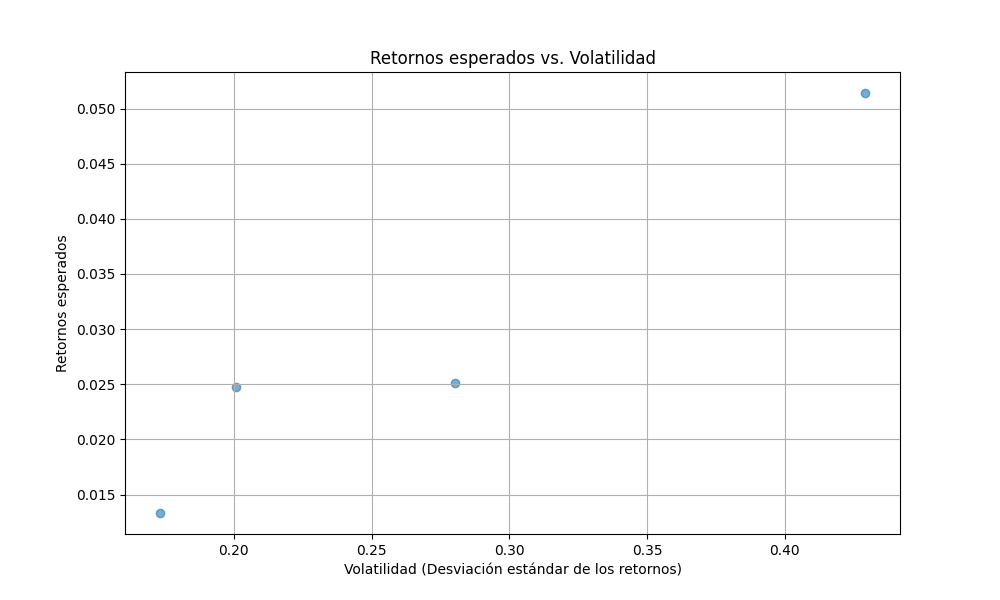

In [ ]:
import matplotlib.pyplot as plt
from google.colab import output
output.enable_custom_widget_manager()

volatilidades = np.sqrt(np.diag(cov_matrix))

plt.figure(figsize=(10, 6))
plt.scatter(volatilidades, retornos_esperados, alpha=0.6)
plt.title('Retornos esperados vs. Volatilidad')
plt.xlabel('Volatilidad (Desviación estándar de los retornos)')
plt.ylabel('Retornos esperados')
plt.grid(True)
plt.show()

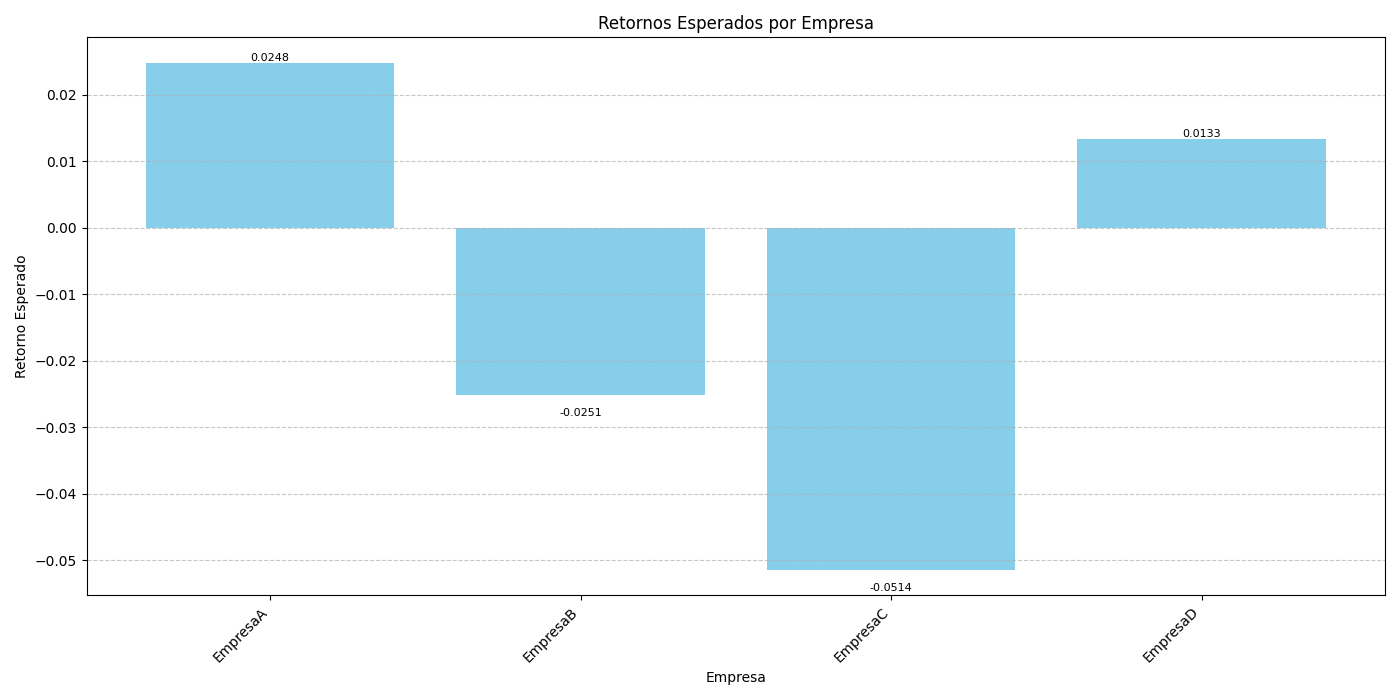

In [ ]:
plt.figure(figsize=(14, 7))
retornos_esperados *= [1 if i not in [asset_names.index('EmpresaB'), asset_names.index('EmpresaC')] else -1 for i in range(len(asset_names))]
bars = plt.bar(asset_names, retornos_esperados, color='skyblue')
plt.title('Retornos Esperados por Empresa')
plt.xlabel('Empresa')
plt.ylabel('Retorno Esperado')
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir el valor de cada barra sobre ella
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval if yval > 0 else yval - 0.002,
             f'{yval:.4f}', ha='center', va='bottom' if yval > 0 else 'top', fontsize=8)

plt.tight_layout()
plt.show()

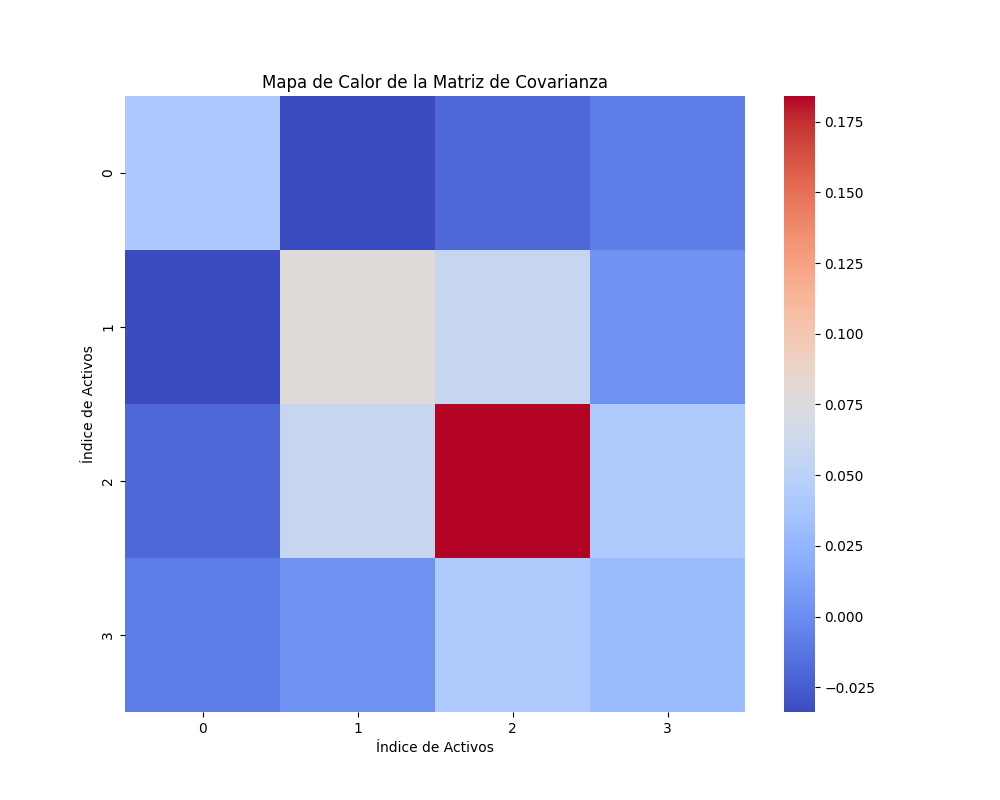

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(cov_matrix, annot=False, cmap='coolwarm', cbar=True)
plt.title('Mapa de Calor de la Matriz de Covarianza')
plt.xlabel('Índice de Activos')
plt.ylabel('Índice de Activos')
plt.show()


## Ejecución en D-Wave

In [ ]:
# experimental:start
def as_bqm(self) -> 'dimod.BinaryQuadraticModel':
    """
    The polynomial is returned as a :class:`dimod.BinaryQuadraticModel` object.

    :return: qubo as dimod.BinaryQuadraticModel object
    :rtype: dimod.BinaryQuadraticModel
    """

    try:
        import dimod
    except Exception as oops:
        print('\n\n' + (100 * '#'))
        print('pip install dwave-ocean-sdk')
        print((100 * '#') + '\n\n')
        raise oops

    return dimod.BinaryQuadraticModel(
        {i0: self._p1[i0] for i0 in self._p1},
        {(i0, i1): self._p2[i0][i1] for i0 in self._p2 for i1 in self._p2[i0]},
        self._p0,
        dimod.BINARY)


In [ ]:
bqm_problem=QUBO.as_bqm()

### Solver Híbrido

In [ ]:
# Mide el tiempo de muestreo
sample_time = time.time()

sampler = LeapHybridSampler()

# Muestreo del problema BQM
answer = sampler.sample(bqm_problem)
print(answer)
print()

# Calcula el tiempo de muestreo
sample_time = time.time() - sample_time

# Análisis de la solución
for datum in answer.data(['sample', 'energy']):
    print("Configuración de solución: ", datum.sample)
    print("Energía: ", datum.energy)

print("Tiempo de muestreo:", sample_time)

   0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15       energy num_oc.
0  0  1  0  1  0  0  0  0  0  1  1  1  1  1  1  1 -7206.959665       1
['BINARY', 1 rows, 1 samples, 16 variables]

Configuración de solución:  {0: 0, 1: 1, 2: 0, 3: 1, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1}
Energía:  -7206.959664618596
Tiempo de muestreo: 7.602718353271484


### Solver Cuántico

In [ ]:
# Mide el tiempo de muestreo
sample_time = time.time()

# Configuración del sampler de D-Wave QPU
sampler = EmbeddingComposite(DWaveSampler())

# Número de lecturas
num_reads = 2000

# Muestreo del problema BQM
sampleset = sampler.sample(bqm_problem, num_reads=num_reads, label='Purely Quantum Exec')

# Calcula el tiempo de muestreo
sample_time = time.time() - sample_time

# Análisis de la solución
for datum in sampleset.lowest().data(['sample', 'energy']):
    print("Configuración de solución: ", datum.sample)
    print("Energía: ", datum.energy)

print("Tiempo de muestreo:", sample_time)

Configuración de solución:  {0: 1, 1: 0, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1}
Energía:  -6767.4841787759215
Tiempo de muestreo: 3.2221100330352783
